In [1]:
main_path='/content/drive/MyDrive/deep learning'
train_data_path=main_path+'/Google_Stock_Price_Train.xls'
test_data_path=main_path+'/Google_Stock_Price_Test.xls'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

In [5]:
train_data.head(2)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"


In [6]:
train_data['Date'],test_data["Date"]=pd.to_datetime(train_data['Date']),pd.to_datetime(test_data['Date'])

In [7]:
#there is issue with volumne data having , in its string
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)
train_data['Close']=train_data['Close'].str.replace(",",'').astype(float)


train_data['Volume'] = pd.to_numeric(train_data['Volume'])
test_data['Volume'] = pd.to_numeric(test_data['Volume'])

In [8]:
train_data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [9]:
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[features_to_scale])

In [ ]:
def convert_data_into_array_of_days(input_data, N, M, feature_idx=None):
    X, y = [], []
    for i in range(len(input_data) - N - M + 1):

        X.append(input_data[i:i+N])  # N timesteps

        if feature_idx is not None:
            # Append the target values for the selected feature
            y.append(input_data[i+N:i+N+M, feature_idx])  # M timesteps
        else:
            # Append the target values for all data features
            y.append(input_data[i+N:i+N+M])  # M time steps

    return np.array(X), np.array(y)

In [ ]:

N, M = 30, 1  # 30 days input, 1 day prediction
feature_idx = 0  # Predicting 'Open' price

In [12]:
X_open, y_open = convert_data_into_array_of_days(scaled_train, N, M, feature_idx)

print(f"X_open shape: {X_open.shape}")  # (samples, 30, 5)
print(f"y_open shape: {y_open.shape}")  # (samples, 1)

X_open shape: (1228, 30, 5)
y_open shape: (1228, 1)


In [ ]:
#validation data : Split data for Open price
X_open_train, X_open_val, y_open_train, y_open_val = train_test_split(
    X_open, y_open, test_size=0.2, random_state=42
)


# Print shapes for Open price as an example
print(f"X_open_train shape: {X_open_train.shape}, X_open_val shape: {X_open_val.shape}")
print(f"y_open_train shape: {y_open_train.shape}, y_open_val shape: {y_open_val.shape}")

X_open_train shape: (982, 30, 5), X_open_val shape: (246, 30, 5)
y_open_train shape: (982, 1), y_open_val shape: (246, 1)


In [ ]:
def optimized_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True,
                                 input_shape=input_shape, recurrent_dropout=0.2)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=False, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=1, kernel_regularizer=l2(0.01)))  # Predict Open price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [19]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10, verbose=1
                               )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=
                                   main_path+'/optimised_lstm_model.keras',
                                   save_best_only=True, monitor='val_loss', verbose=1)


In [20]:
input_shape = (X_open.shape[1], X_open.shape[2])
model_lstm = optimized_lstm_model(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
history = model_lstm.fit(
    X_open_train, y_open_train,
    validation_data=(X_open_val, y_open_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0822
Epoch 1: val_loss improved from inf to 0.02125, saving model to /content/drive/MyDrive/deep learning/optimised_lstm_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - loss: 0.0811 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0264
Epoch 2: val_loss improved from 0.02125 to 0.01988, saving model to /content/drive/MyDrive/deep learning/optimised_lstm_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - loss: 0.0264 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0247
Epoch 3: val_loss improved from 0.01988 to 0.01753, saving model to /content/drive/MyDrive/deep learning/optimised_lstm_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.0247 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0205
Epoch 4: val_loss improved from 0.017

In [22]:
# Scale the test data
scaled_test = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Volume']])


In [23]:
N, M = 30, 1  # Use 30 past days to predict 1 day ahead
feature_idx = 0  # Predicting Open price

X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M, feature_idx=feature_idx)

# Check shapes
print(f"X_test shape: {X_test.shape}")  # (samples, 30, 5)
print(f"y_test shape: {y_test.shape}")  # (samples, 1)

X_test shape: (0,)
y_test shape: (0,)


In [24]:
N = min(10, len(scaled_test) - M)
M = 1


X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M, feature_idx=feature_idx)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10, 10, 5)
y_test shape: (10, 1)


In [25]:
y_pred_scaled_test = model_lstm.predict(X_test)

# Check predicted shape
print(f"Predicted Test Shape: {y_pred_scaled_test.shape}")  # (samples, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
Predicted Test Shape: (10, 1)


In [ ]:
# Inverse transform predictions
y_pred_original_test = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_test, np.zeros((y_pred_scaled_test.shape[0], 4))], axis=1)
)[:, feature_idx]  # Extract the column Open price

# Inverse transform actual test values
y_test_original = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], 4))], axis=1)
)[:, feature_idx]  

In [27]:
compare_table = pd.DataFrame({
    "Actual": y_test_original.flatten(),
    "Predicted": y_pred_original_test.flatten()
})

print(compare_table)

   Actual   Predicted
0  805.81  749.473529
1  805.12  749.949596
2  806.91  750.372217
3  807.25  750.431493
4  822.30  751.029316
5  829.62  752.758060
6  837.81  755.286357
7  834.71  757.402285
8  814.66  758.952881
9  796.86  757.748777


In [28]:
mse_test = mean_squared_error(y_test_original, y_pred_original_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test_original, y_pred_original_test)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")

Test MSE: 4104.93087548543
Test RMSE: 64.06973447334889
Test MAE: 62.76454897022249


In [29]:
y_test_original.shape, y_pred_original_test.shape

((10,), (10,))

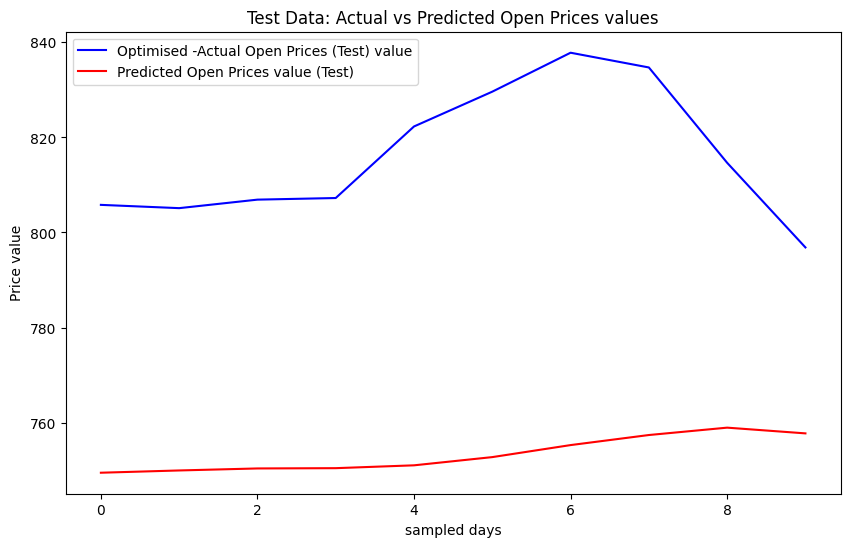

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Optimised -Actual Open Prices (Test) value", color='blue')
plt.plot(y_pred_original_test, label="Predicted Open Prices value (Test)", color='red')
plt.title("Test Data: Actual vs Predicted Open Prices values")
plt.xlabel("sampled days")
plt.ylabel("Price value")
plt.legend()
plt.show()

In [31]:
def model_eval(y_true_scaled, y_pred_scaled, feature_idx, scaler):
    y_pred_original = scaler.inverse_transform(
        np.concatenate([y_pred_scaled, np.zeros((y_pred_scaled.shape[0], 4))], axis=1)
    )[:, feature_idx]

    # Inverse transform true values
    y_true_original = scaler.inverse_transform(
        np.concatenate([y_true_scaled, np.zeros((y_true_scaled.shape[0], 4))], axis=1)
    )[:, feature_idx]

    # Calculate metrics
    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true_original, y_pred_original)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

In [34]:
# Predict on training data
y_pred_scaled_train = model_lstm.predict(X_open_train)

# Predict on validation data
y_pred_scaled_val = model_lstm.predict(X_open_val)

# Predict on test data
y_pred_scaled_test = model_lstm.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Output of train  {'MSE': 182.51569023106472, 'RMSE': 13.509836795130603, 'MAE': 9.417625218880515}
   Actual   Predicted
0  775.48  782.181505
1  717.06  726.455992
2  438.41  440.508032
3  498.63  465.547394
4  584.99  583.639958
5  581.75  576.488904
6  399.05  398.294143
7  539.92  536.374297
8  528.55  539.959437
9  766.69  762.234399


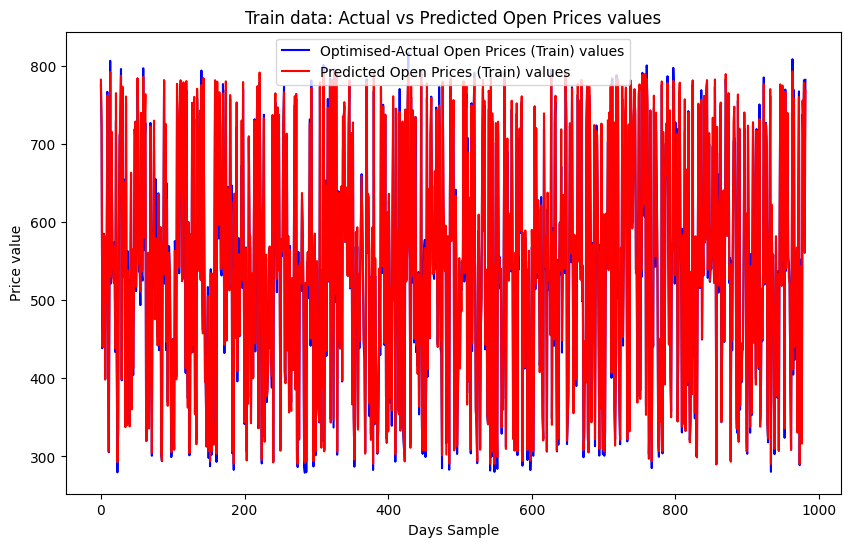

In [35]:
y_pred_original_train = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_train, np.zeros((y_pred_scaled_train.shape[0], 4))], axis=1)
)[:, feature_idx]

y_train_original = scaler.inverse_transform(
    np.concatenate([y_open_train, np.zeros((y_open_train.shape[0], 4))], axis=1)
)[:, feature_idx]

outputs_train=model_eval(y_open_train, y_pred_scaled_train, feature_idx, scaler)
print("Output of train ",outputs_train)

compare_train_table = pd.DataFrame({
    "Actual": y_train_original.flatten(),
    "Predicted": y_pred_original_train.flatten()
})

print(compare_train_table.head(10))

plt.figure(figsize=(10, 6))
plt.plot(y_train_original, label="Optimised-Actual Open Prices (Train) values", color='blue')
plt.plot(y_pred_original_train, label="Predicted Open Prices (Train) values", color='red')
plt.title("Train data: Actual vs Predicted Open Prices values")
plt.xlabel("Days Sample")
plt.ylabel("Price value")
plt.legend()
plt.show()


Output of validation  {'MSE': 271.39756072960273, 'RMSE': 16.474148255057155, 'MAE': 11.133605428931668}
   Actual   Predicted
0  526.35  531.798063
1  577.83  578.884422
2  378.12  376.676079
3  515.76  529.639296
4  777.85  780.598420
5  595.10  604.404304
6  582.16  579.546583
7  516.64  522.243656
8  287.07  295.474589
9  335.80  326.377791


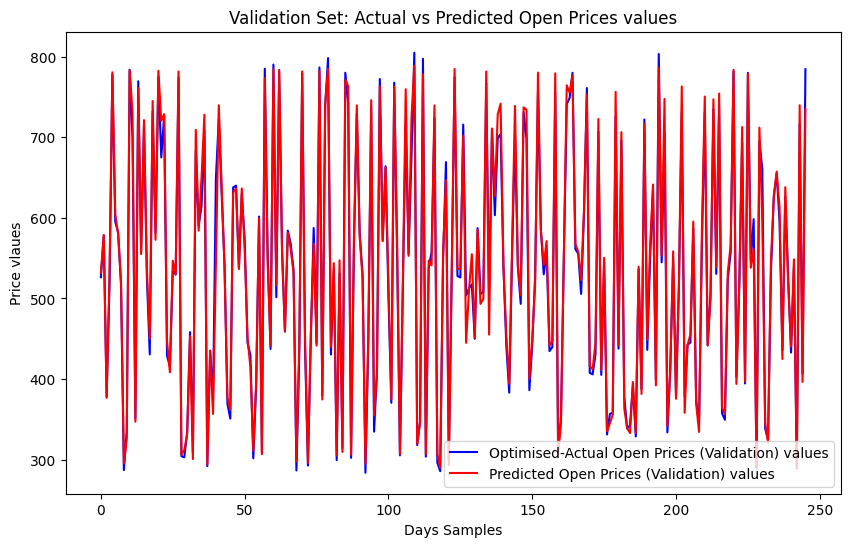

In [36]:
y_pred_original_val = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_val, np.zeros((y_pred_scaled_val.shape[0], 4))], axis=1)
)[:, feature_idx]

y_val_original = scaler.inverse_transform(
    np.concatenate([y_open_val, np.zeros((y_open_val.shape[0], 4))], axis=1)
)[:, feature_idx]

outputs_val=model_eval(y_open_val, y_pred_scaled_val, feature_idx, scaler)
print("Output of validation ",outputs_val)

compare_val_table = pd.DataFrame({
    "Actual": y_val_original.flatten(),
    "Predicted": y_pred_original_val.flatten()
})

print(compare_val_table.head(10))

plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="Optimised-Actual Open Prices (Validation) values", color='blue')
plt.plot(y_pred_original_val, label="Predicted Open Prices (Validation) values", color='red')
plt.title("Validation Set: Actual vs Predicted Open Prices values")
plt.xlabel("Days Samples")
plt.ylabel("Price vlaues")
plt.legend()
plt.show()
